In [1]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [3]:
#  Data generator (load once) 
if !isdefined(Main, :BooleanDataGenerator)
    Base.include(Main, joinpath(@__DIR__, "..", "data", "nested_boolean_gen.jl"))
end
using .BooleanDataGenerator

const HRM_CPU_FILE = joinpath(@__DIR__, "..", "data", "hrm_common_nested_boolean_FLUX.jl")
const HRM_GPU_FILE = joinpath(@__DIR__, "..", "data", "hrm_common_nested_boolean_FLUX_GPU.jl")

const HH_CPU_FILE  = joinpath(@__DIR__, "..", "data", "hh_nested_boolean_FLUX.jl")
const HH_GPU_FILE  = joinpath(@__DIR__, "..", "data", "hh_nested_boolean_FLUX_GPU.jl")  # optional

# GPU check 
hrm_gpu_available = false
gpu_reason = ""
try
    @eval import CUDA
    hrm_gpu_available = isfile(HRM_GPU_FILE) && CUDA.has_cuda_gpu() && CUDA.functional()
    gpu_reason = hrm_gpu_available ? "CUDA: $(CUDA.name(CUDA.device()))" :
                                     "No functional CUDA GPU or missing GPU file"
catch err
    gpu_reason = "CUDA check failed: $(err)"
end

# Choose & include HRMFlux (core HRM) 
if hrm_gpu_available
    Base.include(Main, HRM_GPU_FILE)  # defines module HRMFlux in Main
    HRM_BACKEND = :gpu
    HRM_FILE    = HRM_GPU_FILE
else
    Base.include(Main, HRM_CPU_FILE)
    HRM_BACKEND = :cpu
    HRM_FILE    = HRM_CPU_FILE
end
using .HRMFlux

println("HRMFlux loaded: $(HRM_BACKEND == :gpu ? "GPU" : "CPU") | file: $(HRM_FILE) | $gpu_reason")

# Choose & include HRMFluxHH (H+H baseline) 
hh_gpu_available = false
if hrm_gpu_available && isfile(HH_GPU_FILE)
    Base.include(Main, HH_GPU_FILE)   # defines module HRMFluxHH in Main
    HH_BACKEND = :gpu
    HH_FILE    = HH_GPU_FILE
    hh_gpu_available = true
else
    Base.include(Main, HH_CPU_FILE)
    HH_BACKEND = :cpu
    HH_FILE    = HH_CPU_FILE
end
using .HRMFluxHH

println("HRMFluxHH loaded: $(HH_BACKEND == :gpu ? "GPU" : "CPU") | file: $(HH_FILE) | $gpu_reason")

using StatsBase
using Random, Statistics
using Flux, Zygote, Optimisers
using Flux: onehotbatch, onecold
using DataFrames, Plots, CSV
using Functors
using Functors: @functor
using Random
import Adapt

HRMFlux loaded: GPU | file: /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/../data/hrm_common_nested_boolean_FLUX_GPU.jl | CUDA: Quadro T2000
HRMFluxHH loaded: GPU | file: /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/../data/hh_nested_boolean_FLUX_GPU.jl | CUDA: Quadro T2000


In [4]:
@assert HRM_BACKEND == :gpu
@assert HH_BACKEND == :gpu


In [35]:
using Measures

ArgumentError: ArgumentError: Package Measures not found in current path.
- Run `import Pkg; Pkg.add("Measures")` to install the Measures package.

In [7]:
Base.@kwdef mutable struct TrainLog{T<:AbstractFloat}
    model::String
    epochs::Vector{Int}      = Int[]
    pB::Vector{T}            = T[]
    loss::Vector{T}          = T[]
    id::Vector{T}            = T[]
    mid::Vector{T}           = T[]
    ood::Vector{T}           = T[]
    ood7::Vector{T}          = T[]
    ood8::Vector{T}          = T[]
end

newlog(model::String; T::Type{<:AbstractFloat}=Float32) = TrainLog{T}(model=model)


function push_epoch!(log::TrainLog{T};
    epoch::Integer,
    pB::Real, loss::Real,
    acc_id::Real, acc_mid::Real, acc_ood::Real,
    acc7::Real, acc8::Real
) where {T}
    push!(log.epochs, Int(epoch))
    push!(log.pB,   T(pB))
    push!(log.loss, T(loss))
    push!(log.id,   T(acc_id))
    push!(log.mid,  T(acc_mid))
    push!(log.ood,  T(acc_ood))
    push!(log.ood7, T(acc7))
    push!(log.ood8, T(acc8))
    return log
end
# Training data (depth 2-4)
X_train, y_trainainainain, _ = BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4)

# Test data (depth 5-8) 
X_test, y_test, _ = BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8)

# Test data (held-out NAND)
X_test_ops, y_test_ops, _ = BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND])

function to_dataframe(log::TrainLog{T}) where {T}
    n = length(log.epochs)
    return DataFrame(
        model = fill(log.model, n),
        epoch = log.epochs,
        pB    = log.pB,
        loss  = log.loss,
        ID    = log.id,
        MID   = log.mid,
        OOD   = log.ood,
        OOD7  = log.ood7,
        OOD8  = log.ood8,
    )
end


function summarize(log::TrainLog)
    n = length(log.epochs)
    if n == 0
        return (model=log.model, last=nothing, peak_ood=nothing)
    end
    i_last = n
    i_peak_ood = argmax(log.ood)
    return (
        model = log.model,
        last = (
            epoch = log.epochs[i_last],
            pB    = log.pB[i_last],
            loss  = log.loss[i_last],
            ID    = log.id[i_last],
            MID   = log.mid[i_last],
            OOD   = log.ood[i_last],
            OOD7  = log.ood7[i_last],
            OOD8  = log.ood8[i_last],
        ),
        peak_ood = (
            epoch = log.epochs[i_peak_ood],
            pB    = log.pB[i_peak_ood],
            ID    = log.id[i_peak_ood],
            MID   = log.mid[i_peak_ood],
            OOD   = log.ood[i_peak_ood],
        )
    )
end



summarize (generic function with 1 method)

In [8]:
N_TRAIN = 100
N_TEST  = 20

# ID (train): depths 2 to 4
X_train, y_train, meta_train =
    BooleanDataGenerator.generate_data(N_TRAIN; min_depth=2, max_depth=4)

# MID (test): depth 5
X_test_mid, y_test_mid, meta_mid =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=5, max_depth=5)

# OOD (test): depths 6:8 (aggregate)
X_test_ood, y_test_ood, meta_ood =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=6, max_depth=8)

# OOD by specific depths to match your log columns (OOD7, OOD8)
X_test_ood7, y_test_ood7, _ =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=7, max_depth=7)

X_test_ood8, y_test_ood8, _ =
    BooleanDataGenerator.generate_data(N_TEST; min_depth=8, max_depth=8)

# Held-out operator variant (example: NAND)
X_test_ops, y_test_ops, meta_ops =
    BooleanDataGenerator.generate_data(N_TEST; held_out_ops=[:NAND])


([0 1 … 1 0; 1 1 … 0 1; … ; 1 1 … 0 1; 1 0 … 1 0], [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0], ["(OR x4 x5)", "(NOT x1)", "(XOR x1 (AND x1 x2))", "(AND (XOR x4 (XOR x2 x3)) x3)", "(XOR x3 x5)", "(NOT x1)", "(XOR x1 x1)", "(NOT (AND x5 x1))", "(OR x1 (XOR x5 x2))", "(NOT x2)", "(NOT (OR x1 (AND x1 x3)))", "(NOT (XOR (OR x1 x5) x4))", "(AND x2 (AND x4 x3))", "(AND x1 x2)", "(OR (OR x5 x1) x1)", "(NOT x4)", "(OR x2 x2)", "(AND (XOR x2 x4) x2)", "(AND x4 x4)", "(AND x2 x5)"])

In [9]:
# Generate training data (depth 2-4)
X_train, y_train, expr_train =
    BooleanDataGenerator.generate_data(100; min_depth=2, max_depth=4, seed=42)

# Generate test data with depth generalization (depth 5-8, aggregated)
X_test, y_test, expr_test =
    BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=8, seed=123)

# Generate test data with held-out operations (no NAND)
X_test_ops, y_test_ops, expr_test_ops =
    BooleanDataGenerator.generate_data(20; held_out_ops=[:NAND], seed=456)

println("Training:    X=$(size(X_train)), y=$(size(y_train))")
println("Test (depth): X=$(size(X_test)),  y=$(size(y_test))")
println("Test (ops):   X=$(size(X_test_ops)), y=$(size(y_test_ops))")

println("\nTraining examples:")
for i in 1:min(3, size(X_train, 1))   # guard in case dataset size changes
    println("$(expr_train[i]) | vars=$(X_train[i,:]) → $(y_train[i])")
end

X_test_mid,  y_test_mid,  expr_test_mid  =
    BooleanDataGenerator.generate_data(20; min_depth=5, max_depth=5, seed=223)

X_test_ood7, y_test_ood7, expr_test_ood7 =
    BooleanDataGenerator.generate_data(20; min_depth=7, max_depth=7, seed=224)

X_test_ood8, y_test_ood8, expr_test_ood8 =
    BooleanDataGenerator.generate_data(20; min_depth=8, max_depth=8, seed=225)



Training:    X=(100, 5), y=(100,)
Test (depth): X=(20, 5),  y=(20,)
Test (ops):   X=(20, 5), y=(20,)

Training examples:
(OR x4 x5) | vars=[0, 1, 1, 1, 0] → 1
(NOT x1) | vars=[1, 1, 1, 0, 1] → 0
(NAND x1 (AND x1 x2)) | vars=[0, 1, 1, 0, 1] → 1


([1 1 … 0 0; 1 0 … 1 0; … ; 1 1 … 0 1; 1 0 … 0 0], [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1], ["(NOT (NOT (NOT (AND x2 (AND (NOT (AND x1 x1)) (OR x3 x4))))))", "(AND (NOT (XOR x3 (OR x4 x3))) (NOT (XOR x2 (NAND (AND x1 (AND (XOR x1 x5) x2)) x3))))", "(NOT (NOT (XOR (NOT (NAND (OR (NAND x2 x5) x4) x2)) (AND (NAND x2 x1) x2))))", "(NOT (NOT (XOR (NAND (NAND (NOT (AND x2 x2)) (NOT x1)) (NOT (OR x2 x3))) (XOR x4 x4))))", "(AND x1 (NOT (AND x3 (AND (XOR (NOT (OR x4 x2)) (OR x1 x4)) x4))))", "(NAND (NOT (XOR x3 (NOT (OR (NAND (NOT x1) x4) (XOR x1 x2))))) (XOR x1 (XOR (XOR x3 x2) x1)))", "(NOT (AND (XOR (NOT x5) (NOT (NOT (OR (NOT x2) (XOR x1 x2))))) (OR x5 (AND x2 x3))))", "(AND (NOT (OR (AND (NOT (AND (XOR x2 x2) x2)) x1) (XOR x5 x2))) x2)", "(AND x1 x2)", "(NAND (NOT (NOT (AND (NAND x3 x2) x5))) (NOT (NOT (AND (XOR (XOR x2 x4) x1) (OR (XOR (OR x4 x3) x2) (NOT x4))))))", "(NOT (NAND (OR (NOT (NAND x1 x4)) (OR (NAND (AND x2 x1) (NOT (OR x2 x5))) x1)) (OR (AND (NOT (OR x3 x

In [10]:

VAR_COUNT = 6
N_TRAIN   = 2000
N_ID      = 500
N_OOD     = 500
SEEDS     = (; train=1, id=2, ood=3)

# Train (depth 2-4)
X_train, y_train, expr_train =
    BooleanDataGenerator.generate_data(N_TRAIN;
        variable_count=VAR_COUNT, min_depth=2, max_depth=4, seed=SEEDS.train)

# Test ID (depth 2-4)
X_id, y_test_id, expr_id =
    BooleanDataGenerator.generate_data(N_ID;
        variable_count=VAR_COUNT, min_depth=2, max_depth=4, seed=SEEDS.id)

# Test OOD (depth 5-8)
X_ood, y_ood, expr_ood =
    BooleanDataGenerator.generate_data(N_OOD;
        variable_count=VAR_COUNT, min_depth=5, max_depth=8, seed=SEEDS.ood)


X_test_id      = X_id
y_id           = y_test_id
expr_test_id   = expr_id

X_test_ood     = X_ood
y_test_ood     = y_ood
expr_test_ood  = expr_ood

# Sanity checks (catch accidental shape mismatches early)
@assert size(X_train, 2) == VAR_COUNT
@assert size(X_id, 2)    == VAR_COUNT
@assert size(X_ood, 2)   == VAR_COUNT

@info "Splits ready" train=size(X_train,1) id=size(X_id,1) ood=size(X_ood,1)


┌ Info: Splits ready
│   train = 2000
│   id = 500
│   ood = 500
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:37


In [11]:
# Tokenize an expression like "x1 AND (x2 XOR NOT x3)" into:
# ["x1=1","AND","x2=0","XOR","NOT","x3=1"], dropping parentheses.
function tokenize_with_assignment(expression::AbstractString,
    variable_row::AbstractVector{<:Integer})
    # Faster than a regex: remove parentheses by replacing with spaces
    sanitized = replace(expression, '(' => ' ', ')' => ' ')
    raw_tokens = split(strip(sanitized))

    tokens = String[]
    for t in raw_tokens
        if !isempty(t) && t[1] == 'x' && length(t) > 1
            # parse index after 'x'
            idx = parse(Int, t[2:end])
            @assert 1 ≤ idx ≤ length(variable_row) "Variable index $idx out of bounds (len=$(length(variable_row)))"
            @inbounds val = variable_row[idx]
            push!(tokens, "x$(idx)=$(val)")
        elseif t == "(" || t == ")"
            # Should not occur after sanitization, but keep for robustness
            continue
        else
        # operator token: "AND", "OR", "XOR", "NAND", "NOT"
        push!(tokens, t)
        end
    end
        return tokens
end

    # Build token sequences for a batch of expressions and an assignment matrix X
    # (rows correspond to expressions).
function build_token_sequences(expressions::AbstractVector{<:AbstractString},
    X::AbstractMatrix{<:Integer})
    @assert size(X, 1) == length(expressions) "Row count of X must match expressions length"
    seqs = Vector{Vector{String}}(undef, length(expressions))
    @inbounds @views for i in eachindex(expressions)
        seqs[i] = tokenize_with_assignment(expressions[i], X[i, :])
    end
    return seqs
end

# Build token sequences (names unchanged)
train_tokens = build_token_sequences(expr_train, X_train)
id_tokens    = build_token_sequences(expr_id,    X_id)
ood_tokens   = build_token_sequences(expr_ood,   X_ood)



500-element Vector{Vector{String}}:
 ["NOT", "NOT", "XOR", "x6=0", "OR", "x1=0", "x3=0"]
 ["NOT", "NOT", "NAND", "NOT", "NOT", "x5=0", "AND", "NOT", "NOT", "x1=0", "x3=1"]
 ["OR", "OR", "AND", "x5=1", "x5=1", "x6=1", "XOR", "XOR", "NAND", "x1=1", "x3=1", "XOR", "x2=1", "x6=1", "x6=1"]
 ["NOT", "AND", "NOT", "x3=0", "NOT", "NOT", "NOT", "x1=0"]
 ["OR", "x5=1", "NOT", "OR", "XOR", "x1=1", "OR", "x6=1", "x3=0", "x2=1"]
 ["NAND", "NOT", "NAND", "NOT", "x4=0", "NAND", "x4=0", "x5=0", "OR", "NOT", "x1=1", "OR", "x4=0", "x5=0"]
 ["NOT", "OR", "NOT", "NAND", "AND", "x3=1", "x3=1", "x5=1", "XOR", "x4=1", "AND", "x3=1", "XOR", "x3=1", "x2=0"]
 ["NOT", "NOT", "AND", "x6=1", "XOR", "AND", "x5=0", "XOR", "x3=1", "x5=0", "NOT", "x1=1"]
 ["AND", "NOT", "AND", "XOR", "x4=1", "AND", "NAND", "x3=1", "x4=1", "x5=0", "x4=1", "x4=1"]
 ["NOT", "NOT", "AND", "NOT", "x3=1", "x6=1"]
 ⋮
 ["OR", "NOT", "OR", "x6=1", "x5=0", "NOT", "NOT", "NOT", "x4=1"]
 ["NAND", "NOT", "x2=1", "NAND", "NAND", "x4=1", "OR", "x6=1

In [12]:

"""
    build_vocab(token_sequences; pad_id=nothing, add_unk=true)

Build a token→id dictionary from `token_sequences` (list of token lists).
Returns (vocab::Dict{String,Int}, id_to_token::Vector{String}, unk_id::Union{Int,Nothing}).

Notes:
- IDs start at 1 and follow first-appearance order in training.
- If `add_unk=true`, reserve a new id for unknown tokens at the end and return it as `unk_id`.
- `pad_id` is not used here (your model masks padding separately); pass it if you want to
  reserve an index upfront later.
"""
function build_vocab(token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}};
                     pad_id::Union{Nothing,Int}=nothing,
                     add_unk::Bool=true)
    vocab = Dict{String,Int}()
    next_id = 1

    if pad_id !== nothing
        @assert pad_id ≥ 1 "pad_id must be ≥ 1 for Flux.Embedding indices"
        vocab["<PAD>"] = pad_id
        next_id = max(next_id, pad_id + 1)
    end

    # Insert tokens in first-appearance order
    for seq in token_sequences
        @inbounds for t in seq
            if !haskey(vocab, t)
                vocab[t] = next_id
                next_id += 1
            end
        end
    end

    # Optional UNK
    unk_id = nothing
    if add_unk
        unk_id = next_id
        vocab["<UNK>"] = unk_id
        next_id += 1
    end

    # Build reverse map for debugging/inspection
    id_to_token = Vector{String}(undef, length(vocab))
    for (tok, id) in vocab
        id_to_token[id] = tok
    end

    return vocab, id_to_token, unk_id
end

# Map tokens -> ids (ragged lists in, ragged lists out; padding happens later)
function map_to_ids(token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}},
                    vocab::Dict{String,Int}, unk_id::Union{Int,Nothing})
    # If unk_id is nothing, unknowns will throw a KeyError (good to catch surprises)
    if unk_id === nothing
        return [map(t -> vocab[t], seq) for seq in token_sequences]
    else
        return [map(t -> get(vocab, t, unk_id), seq) for seq in token_sequences]
    end
end

PAD_ID = 1

vocab, id_to_token, unk_id = build_vocab(train_tokens; pad_id=PAD_ID, add_unk=true)

train_ids = map_to_ids(train_tokens, vocab, unk_id)
id_ids    = map_to_ids(id_tokens,    vocab, unk_id)
ood_ids   = map_to_ids(ood_tokens,   vocab, unk_id)

# Optional: quick OOV diagnostics
let count_oov = seqs -> sum(t -> !haskey(vocab, t), Iterators.flatten(seqs))
    oov_id = count_oov(id_tokens)
    oov_ood = count_oov(ood_tokens)
    if (oov_id + oov_ood) > 0
        @info "OOV tokens encountered" id=oov_id ood=oov_ood unk_id=unk_id
    end
end


In [15]:
# Guard constants so re-running the cell doesn't warn about redefinition.
if !isdefined(@__MODULE__, :VARIABLE_COUNT); VARIABLE_COUNT = 6; end
if !isdefined(@__MODULE__, :N_A);            N_A   = 5000;  end   # Train Phase A (2–4)
if !isdefined(@__MODULE__, :N_B);            N_B   = 10000; end   # Train Phase B (2–6)
if !isdefined(@__MODULE__, :N_ID);           N_ID  = 1000;  end   # Test (2–4)
if !isdefined(@__MODULE__, :N_MID);          N_MID = 1000;  end   # Test (5–6)
if !isdefined(@__MODULE__, :N_OOD);          N_OOD = 1000;  end   # Test (7–8)


function max_paren_depth(expr::AbstractString)
    d = 0; m = 0
    @inbounds for c in expr
        if c == '('
            d += 1
            m = ifelse(d > m, d, m)
        elseif c == ')'
            d -= 1
            @assert d ≥ 0 "Unbalanced ')': more closing than opening parentheses in: $expr"
        end
    end
    @assert d == 0 "Unbalanced '(': more opening than closing parentheses in: $expr"
    return m
end


function make_depth_stratified_split(depth_counts::Dict{Int,Int};
                                     variable_count::Int,
                                     seed::Integer)
    Xs = Matrix{Int}[]
    ys = Vector{Int}[]
    Es = Vector{String}[]

    for d in sort(collect(keys(depth_counts)))
        n = Int(depth_counts[d])
        n == 0 && continue
        X, y, E = BooleanDataGenerator.generate_data(
            n; variable_count=variable_count, min_depth=d, max_depth=d,
            seed=seed + d, mode=:exact
        )
        @assert size(X, 2) == variable_count
        push!(Xs, X)
        push!(ys, y)
        push!(Es, E)
    end

    if isempty(Xs)
        return Array{Int}(undef, 0, variable_count), Int[], String[]
    end

    X_all = vcat(Xs...)              # (N_total, variable_count)
    y_all = vcat(ys...)              # (N_total,)
    E_all = vcat(Es...)              # (N_total,)

    # Shuffle rows reproducibly with a local RNG
    rng  = Random.MersenneTwister(Int(seed) + 10_000)
    perm = randperm(rng, size(X_all, 1))
    return X_all[perm, :], y_all[perm], E_all[perm]
end


make_depth_stratified_split (generic function with 1 method)

In [16]:

# split N "equal-ish" across given depths
function equalish_counts(depths::AbstractVector{<:Integer}, N::Integer; remainder_to::Symbol=:last)
    m = length(depths)
    @assert m ≥ 1
    base = N ÷ m
    counts = fill(Int(base), m)
    rem   = N - base * m
    if remainder_to === :last
        counts[end] += rem
    elseif remainder_to === :distribute
        # spread the remainder across the first 'rem' depths deterministically
        for i in 1:rem
            counts[i] += 1
        end
    else
        error("remainder_to must be :last or :distribute")
    end
    dict = Dict(d => counts[i] for (i, d) in enumerate(depths))
    @assert sum(values(dict)) == N
    return dict
end

# Train Phase A: (2,3,4)
counts_A = equalish_counts([2,3,4], N_A; remainder_to=:last)
X_tr_A, y_tr_A, expr_tr_A =
    make_depth_stratified_split(counts_A; variable_count=VARIABLE_COUNT, seed=101)

# Train Phase B: (2,3,4,5,6)
counts_B = equalish_counts([2,3,4,5,6], N_B; remainder_to=:last)
X_tr_B, y_tr_B, expr_tr_B =
    make_depth_stratified_split(counts_B; variable_count=VARIABLE_COUNT, seed=102)

# Test ID: (2,3,4)
counts_ID = equalish_counts([2,3,4], N_ID; remainder_to=:last)
X_te_ID,  y_te_ID,  expr_te_ID  =
    make_depth_stratified_split(counts_ID; variable_count=VARIABLE_COUNT, seed=201)

# Test MID: (5,6)
counts_MID = equalish_counts([5,6], N_MID; remainder_to=:last)
X_te_MID, y_te_MID, expr_te_MID =
    make_depth_stratified_split(counts_MID; variable_count=VARIABLE_COUNT, seed=202)

# Test OOD: (7,8)
counts_OOD = equalish_counts([7,8], N_OOD; remainder_to=:last)
X_te_OOD, y_te_OOD, expr_te_OOD =
    make_depth_stratified_split(counts_OOD; variable_count=VARIABLE_COUNT, seed=203)

# Sanity check: confirm OOD expressions are depth 7 or 8
let d = [max_paren_depth(e) + 1 for e in expr_te_OOD]
    # tiny countmap without StatsBase
    cm = Dict{Int,Int}()
    for x in d
        cm[x] = get(cm, x, 0) + 1
    end
    @assert all(x -> x == 7 || x == 8, d) "Found non-(7,8) depths in OOD split: $cm"
end


In [17]:

# Tokenize an expression like "x1 AND (x2 XOR NOT x3)" into:
# ["x1=1","AND","x2=0","XOR","NOT","x3=1"], dropping parentheses for shorter sequences
function tokenize_with_assignment(expression::AbstractString,
    variable_row::AbstractVector{<:Integer})
    # Faster and simpler than a regex: remove parentheses by replacing with spaces
    sanitized   = replace(expression, '(' => ' ', ')' => ' ')
    raw_tokens  = split(strip(sanitized))

    tokens = String[]
    @inbounds for t in raw_tokens
        if !isempty(t) && t[1] == 'x' && length(t) > 1
            # parse index after 'x'
            idx = parse(Int, t[2:end])
            @assert 1 ≤ idx ≤ length(variable_row) "Variable index $idx out of bounds (len=$(length(variable_row)))"
            val = variable_row[idx]
            push!(tokens, "x$(idx)=$(val)")
        else
            # operator token: "AND", "OR", "XOR", "NAND", "NOT" (parentheses already removed)
            push!(tokens, t)
        end
    end
    return tokens
end

# Build token sequences for a batch of expressions and an assignment matrix X
# (each row of X corresponds to one expression)
function build_token_sequences(expressions::AbstractVector{<:AbstractString},
 X::AbstractMatrix{<:Integer})
    @assert size(X, 1) == length(expressions) "Row count of X must match expressions length"
    seqs = Vector{Vector{String}}(undef, length(expressions))
    @inbounds @views for i in eachindex(expressions)
        seqs[i] = tokenize_with_assignment(expressions[i], X[i, :])
    end
    return seqs
end


build_token_sequences (generic function with 1 method)

In [18]:
# Tokenize every split (unchanged)
tokens_tr_A  = build_token_sequences(expr_tr_A,  X_tr_A)
tokens_tr_B  = build_token_sequences(expr_tr_B,  X_tr_B)
tokens_te_ID = build_token_sequences(expr_te_ID, X_te_ID)
tokens_te_M  = build_token_sequences(expr_te_MID, X_te_MID)
tokens_te_O  = build_token_sequences(expr_te_OOD, X_te_OOD)

# Build vocab with <PAD>=1 and <UNK>=2, preserving first-seen order from training
function build_vocab_with_specials(train_token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}})
    vocab = Dict{String,Int}("<PAD>" => 1, "<UNK>" => 2)
    next_id = 3
    @inbounds for seq in train_token_sequences
        for t in seq
            if !haskey(vocab, t)
                vocab[t] = next_id
                next_id += 1
            end
        end
    end
    return vocab
end

vocab = build_vocab_with_specials(tokens_tr_A)
PAD_ID = vocab["<PAD>"]  # 1 (safe for Flux.Embedding)
UNK_ID = vocab["<UNK>"]  # 2

# Keep the same helper name; make it typed and fast
token_to_id(t::AbstractString) = get(vocab, t, UNK_ID)

# Map ragged token lists -> (L, N) integer ID matrix, padded with PAD_ID
# (left-aligned; trailing rows are PAD)
function to_ids(tokens::AbstractVector{<:AbstractVector{<:AbstractString}})
    n = length(tokens)
    Lmax = (n == 0) ? 0 : maximum(length.(tokens))
    Xids = fill(Int(PAD_ID), Lmax, n)
    @inbounds for i in 1:n
        s = tokens[i]
        len = length(s)
        for j in 1:len
            Xids[j, i] = token_to_id(s[j])
        end
    end
    return Xids
end


to_ids (generic function with 1 method)

In [19]:
if !isdefined(@__MODULE__, :build_vocab_with_specials)
    function build_vocab_with_specials(train_token_sequences::AbstractVector{<:AbstractVector{<:AbstractString}})
        vocab = Dict{String,Int}("<PAD>" => 1, "<UNK>" => 2)
        next_id = 3
        @inbounds for seq in train_token_sequences
            for t in seq
                if !haskey(vocab, t)
                    vocab[t] = next_id
                    next_id += 1
                end
            end
        end
        return vocab
    end
end

# Build once per session to keep ids stable
if !isdefined(@__MODULE__, :vocab)
    vocab = build_vocab_with_specials(tokens_tr_A)   # Phase-A only, prevents test leakage
end

# Define PAD/UNK once (constants); safe for repeated cell runs
if !isdefined(@__MODULE__, :PAD_ID)
    PAD_ID = vocab["<PAD>"]  # = 1
    UNK_ID = vocab["<UNK>"]  # = 2
end

# token_to_id helper (guarded)
if !isdefined(@__MODULE__, :token_to_id)
    token_to_id(t::AbstractString) = get(vocab, t, UNK_ID)
end


Xids_tr_A  = to_ids(tokens_tr_A)
Xids_tr_B  = to_ids(tokens_tr_B)
Xids_te_ID = to_ids(tokens_te_ID)
Xids_te_M  = to_ids(tokens_te_M)
Xids_te_O  = to_ids(tokens_te_O)

L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)

L_MAX = maximum((L_A, L_B, L_ID, L_MID, L_OOD))


40

In [20]:
if !isdefined(@__MODULE__, :to_ids)
    # Requires `PAD_ID` and `token_to_id` (defined in earlier cell)
    function to_ids(tokens::AbstractVector{<:AbstractVector{<:AbstractString}})
        n = length(tokens)
        Lmax = (n == 0) ? 0 : maximum(length.(tokens))
        Xids = fill(Int(PAD_ID), Lmax, n)
        @inbounds for i in 1:n
            s = tokens[i]
            len = length(s)
            for j in 1:len
                Xids[j, i] = token_to_id(s[j])
            end
        end
        return Xids
    end
end

Xids_tr_A  = to_ids(tokens_tr_A)
Xids_tr_B  = to_ids(tokens_tr_B)
Xids_te_ID = to_ids(tokens_te_ID)
Xids_te_M  = to_ids(tokens_te_M)
Xids_te_O  = to_ids(tokens_te_O)

L_A   = size(Xids_tr_A,  1)
L_B   = size(Xids_tr_B,  1)
L_ID  = size(Xids_te_ID, 1)
L_MID = size(Xids_te_M,  1)
L_OOD = size(Xids_te_O,  1)
L_MAX = maximum((L_A, L_B, L_ID, L_MID, L_OOD))  # for positional encodings / sanity


cfg = (
    d_in        = 0,
    d_hid       = 128,
    d_out       = 1,
    N           = 5,
    T           = L_MAX,
    batch       = 32,
    lr          = 1f-4,    # Float32 for GPU/mixed-precision friendliness
    num_tokens  = length(vocab),
    d_embed     = 128,
    l_heads     = 4,
    l_ff_mult   = 6,
    h_heads     = 4,
    h_ff_mult   = 6,
    dropout     = 0.15f0,  # Float32
    pad_id      = PAD_ID,
)


depths(v) = (max_paren_depth.(v) .+ 1)
@show StatsBase.countmap(depths(expr_tr_A))
@show StatsBase.countmap(depths(expr_tr_B))
@show StatsBase.countmap(depths(expr_te_ID))
@show StatsBase.countmap(depths(expr_te_MID))
@show StatsBase.countmap(depths(expr_te_OOD))


StatsBase.countmap(depths(expr_tr_A)) = Dict(4 => 1668, 2 => 1666, 3 => 1666)
StatsBase.countmap(depths(expr_tr_B)) = Dict(5 => 2000, 4 => 2000, 6 => 2000, 2 => 2000, 3 => 2000)
StatsBase.countmap(depths(expr_te_ID)) = Dict(4 => 168, 2 => 166, 3 => 166)
StatsBase.countmap(depths(expr_te_MID)) = Dict(5 => 500, 6 => 500)
StatsBase.countmap(depths(expr_te_OOD)) = Dict(7 => 250, 8 => 250)


Dict{Int64, Int64} with 2 entries:
  7 => 250
  8 => 250

In [21]:
# +1 if you use CLS (the CLS token is prepended to H_in)
POS_L_MAX = max(L_A, L_B, L_ID, L_MID, L_OOD) + 1

models = HRMFlux.build_models(cfg;
    l_positional_encoding_kind = :none,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX,
)

# If you're running the GPU path and haven't moved yet, do:
# models = Functors.fmap(gpu, models)

# Left-aligned lengths from PAD
function seq_lengths_from_pad_id(Xids::AbstractMatrix{<:Integer}, pad_id::Integer)
    L, B = size(Xids)
    lengths = Vector{Int}(undef, B)
    @inbounds for b in 1:B
        len = L
        for t in 1:L
            if Xids[t, b] == pad_id
                len = t - 1
                break
            end
        end
        lengths[b] = len
    end
    return lengths
end

# Keep PAD embedding at zero to avoid length bias (dtype/device-safe)
if models.tok_emb !== nothing
    w = models.tok_emb.weight                 # could be CPU or CuArray, Float16/32/etc.
    fill!(view(w, :, PAD_ID), zero(eltype(w)))
end


128-element view(::Matrix{Float32}, :, 1) with eltype Float32:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [22]:
# Bucketed mini-batches by (padded) sequence length, GPU-safe
function each_minibatch_bucketed(X::AbstractMatrix{<:Integer},
    y::AbstractVector{<:Integer};
    batch::Int,
    buckets::Int = 6,
    pad_id::Integer = PAD_ID)

    @assert size(X, 2) == length(y) "columns of X must match length(y)"
    L, N = size(X)
    buckets = max(1, buckets)

    # GPU-safe length computation: count non-PAD per column (left-aligned padding)
    # lens_raw has shape (1, N) and lives on the same device as X
    lens_raw = sum(X .!= pad_id, dims = 1)
    # bring small 1×N vector to CPU for sorting/partitioning
    lens = vec(Array(lens_raw))

    # Sort column indices by length, then partition into buckets of ~equal size
    order = sortperm(1:N, by = i -> lens[i])
    group_size = max(1, ceil(Int, N / buckets))

    # Keep container type flexible (CPU or GPU) by inferring from a typical slice
    Tmat = typeof(X[:, 1:1])
    Tvec = typeof(y[1:1])
    out  = Vector{Tuple{Tmat, Tvec}}()

    # Shuffle within each bucket and emit contiguous batches
    @inbounds for gstart in 1:group_size:N
        gend = min(gstart + group_size - 1, N)
        idx = copy(order[gstart:gend])
        Random.shuffle!(idx)
        for k in 1:batch:length(idx)
            sel = idx[k:min(k + batch - 1, length(idx))]
            push!(out, (X[:, sel], y[sel]))
        end
    end
    return out
end

# Simple global shuffle minibatches, GPU-safe (keeps X's device)
function each_minibatch(X::AbstractMatrix{<:Integer},
    y::AbstractVector{<:Integer},
    batch_size::Int)
    @assert size(X, 2) == length(y)
    idx = collect(1:size(X, 2))
    Random.shuffle!(idx)

    Tmat = typeof(X[:, 1:1])
    Tvec = typeof(y[1:1])
    out  = Vector{Tuple{Tmat, Tvec}}()

    @inbounds for k in 1:batch_size:length(idx)
        sel = idx[k:min(k + batch_size - 1, length(idx))]
        push!(out, (X[:, sel], y[sel]))
    end
    return out
end


each_minibatch (generic function with 1 method)

In [23]:


"Yield a mixed stream of mini-batches from A and B with probability pB for B."
function each_minibatch_mixed(XA::AbstractMatrix{<:Integer}, yA::AbstractVector{<:Integer},
                              XB::AbstractMatrix{<:Integer}, yB::AbstractVector{<:Integer};
                              batch::Int, pB::Real, buckets::Int=6, pad_id::Integer=PAD_ID,
                              rng::AbstractRNG=Random.GLOBAL_RNG)

    @assert size(XA,2) == length(yA) "XA and yA mismatch"
    @assert size(XB,2) == length(yB) "XB and yB mismatch"
    @assert 0 ≤ pB ≤ 1

    itA = each_minibatch_bucketed(XA, yA; batch=batch, buckets=buckets, pad_id=pad_id)
    itB = each_minibatch_bucketed(XB, yB; batch=batch, buckets=buckets, pad_id=pad_id)

    # Ensure both sets live on the same device (important if you move X to GPU)
    same_device = (XA isa CUDA.CuArray) == (XB isa CUDA.CuArray)
    @assert same_device "XA and XB are on different devices (CPU vs GPU)."

    # Create a *typed* vector for output tuples that preserves device
    Tmat = typeof(XA[:, 1:1])   # slice type preserves CPU/GPU
    Tvec = typeof(yA[1:1])
    out  = Vector{Tuple{Tmat,Tvec}}()

    ia = 1; ib = 1
    while ia ≤ length(itA) || ib ≤ length(itB)
        useB = rand(rng) < pB
        if useB && ib ≤ length(itB)
            push!(out, itB[ib]); ib += 1
        elseif ia ≤ length(itA)
            push!(out, itA[ia]); ia += 1
        elseif ib ≤ length(itB)
            push!(out, itB[ib]); ib += 1
        end
    end
    return out
end

# Helper: adapt states to the model’s device/dtype using a weight as template
states_like(models, batch_size::Int, d_hid::Int) = begin
    low_state, high_state = HRMFlux.init_states(batch_size, d_hid)  # CPU Float32 by default
    # Use Hpost’s first Dense weight as a reliable template
    template = models.Hpost.layers[1].weight
    low_state  = Adapt.adapt(typeof(template), low_state)
    high_state = Adapt.adapt(typeof(template), high_state)
    return low_state, high_state
end

import Adapt

function batch_loss(models, x_batch::AbstractMatrix{<:Integer},
    y_batch::AbstractVector{<:Integer}, cfg)
    bs = size(x_batch, 2)
    template = models.Hpost.layers[1].weight

    # States on the model device/dtype without Adapt in AD path
    low_state  = HRMFlux.device_zeros(template, eltype(template), cfg.d_hid, bs)
    high_state = HRMFlux.device_zeros(template, eltype(template), cfg.d_hid, bs)

    # Indices on device
    xb_dev = HRMFlux.to_device_like_indices(Int32.(x_batch), template)

    yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb_dev, low_state, high_state; N=cfg.N, cfg=cfg)

    # Targets moved/cast with @nograd helper
    targets = reshape(eltype(yhat).(y_batch), 1, bs)
    targets = HRMFlux.to_device_and_match_eltype(targets, yhat)

    return Flux.logitbinarycrossentropy(yhat, targets)
end




batch_loss (generic function with 1 method)

In [24]:
import Adapt

function accuracy(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    @assert size(X, 2) == length(y) "columns of X must match length(y)"
    correct = 0
    total   = 0

    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=cfg.pad_id)
        bs = size(xb, 2)

        # States on same device/dtype as the model
        low_state, high_state = HRMFlux.init_states(bs, cfg.d_hid)
        template = models.Hpost.layers[1].weight
        low_state  = Adapt.adapt(typeof(template), low_state)
        high_state = Adapt.adapt(typeof(template), high_state)

        # Forward (sequence path) — ensure Int32 indices on the model's device
        xb32   = Int32.(xb)
        xb_dev = HRMFlux.to_device_like_indices(xb32, template)
        yhat, _, _ = HRMFlux.run_sequence_segment!(models, xb_dev, low_state, high_state; N=cfg.N, cfg=cfg)


        # Move the single logit row to CPU; avoid GPU scalar ops
        logits_cpu = Array(yhat[1, :])
        preds_cpu  = logits_cpu .> zero(eltype(logits_cpu))   # Bool vector length = bs

        correct += sum(Int.(preds_cpu) .== yb)
        total   += bs
    end

    return total == 0 ? NaN : correct / total
end

function accuracy_by_depth(models,
                           Xids::AbstractMatrix{<:Integer},
                           y::AbstractVector{<:Integer},
                           exprs::AbstractVector{<:AbstractString};
                           cfg, batch_size::Int=256)
    @assert size(Xids, 2) == length(y) == length(exprs)

    # structural depths
    de = max_paren_depth.(exprs) .+ 1

    # group indices by depth
    buckets = Dict{Int, Vector{Int}}()
    @inbounds for (i, d) in pairs(de)
        push!(get!(buckets, d, Int[]), i)
    end

    # compute accuracy per depth, sorted by depth
    out = Dict{Int, Float64}()
    for (d, idx) in sort(collect(buckets); by=first)
        xsub = Xids[:, idx]               # NOTE: slice, not @view (idx is a vector)
        out[d] = accuracy(models, xsub, y[idx], cfg; batch_size=batch_size)
    end
    return out
end



# Sanity checks (unchanged)
@assert size(X_tr_A,2) == VARIABLE_COUNT
@assert length(y_tr_A) == size(X_tr_A,1) == length(expr_tr_A)
@assert length(y_tr_B) == size(X_tr_B,1) == length(expr_tr_B)
@assert length(y_te_ID)  == size(X_te_ID,1)  == length(expr_te_ID)
@assert length(y_te_MID) == size(X_te_MID,1) == length(expr_te_MID)
@assert length(y_te_OOD) == size(X_te_OOD,1) == length(expr_te_OOD)

@assert size(Xids_tr_A,2) == size(X_tr_A,1)
@assert size(Xids_te_O, 2) == size(X_te_OOD,1)

In [25]:

# existing sanity checks (unchanged)
@assert size(X_tr_A,2) == VARIABLE_COUNT
@assert length(y_tr_A) == size(X_tr_A,1) == length(expr_tr_A)
@assert length(y_tr_B) == size(X_tr_B,1) == length(expr_tr_B)
@assert length(y_te_ID)  == size(X_te_ID,1)  == length(expr_te_ID)
@assert length(y_te_MID) == size(X_te_MID,1) == length(expr_te_MID)
@assert length(y_te_OOD) == size(X_te_OOD,1) == length(expr_te_OOD)
@assert size(Xids_tr_A,2) == size(X_tr_A,1)
@assert size(Xids_te_O, 2) == size(X_te_OOD,1)


In [ ]:
epochs_A = 3    # Phase A (2-4)
epochs_B = 3    # Phase B (2-6)

# Helper: keep PAD column neutral (device & dtype safe)
zero_pad_embedding!(m, pad_id) = begin
    if hasproperty(m, :tok_emb) && m.tok_emb !== nothing
        w = m.tok_emb.weight                     # CPU or CuArray, Float16/32/…
        fill!(view(w, :, pad_id), zero(eltype(w)))
    end
    nothing
end

if CUDA.has_cuda_gpu() && CUDA.functional()
    models = gpu(models)
    CUDA.allowscalar(false)
    Flux.testmode!(models, true)
end


to_device_like(x, tmpl) = tmpl isa CUDA.CuArray ? CUDA.cu(x) : x
adapt_like(x, tmpl)     = Adapt.adapt(typeof(tmpl), x)



adapt_like (generic function with 1 method)

In [ ]:
# curriculum phases xxx
using Flux: gpu, testmode!
using Adapt


# cfg_hl = (CUDA.has_cuda_gpu() && CUDA.functional()) ? merge(cfg, (; dropout = 0f0)) : cfg
models = HRMFlux.build_models(cfg;
    l_positional_encoding_kind = :none,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX,        # or your chosen max
)


total_epochs = epochs_A + epochs_B

base_lr  = cfg.lr
opt      = Optimisers.Adam(base_lr)
opt_state = Optimisers.setup(opt, models)

# cosine ramp helpers & bounds for Phase-B mixing
MIN_MIX_IN_B = 0.30     # lower bound once Phase B starts
MAX_MIX_IN_B = 1.00     # cap at full B
cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))   # maps [0,1] -> [0,1] smoothly

@info "Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B)"

log_HL = newlog("H+L")


# one-time device probe before training

let B = min(cfg.batch, size(Xids_tr_A,2))
    xb = Xids_tr_A[:, 1:B]
    low, high = HRMFlux.init_states(B, cfg.d_hid)
    tmpl = models.Hpost.layers[1].weight
    low  = Adapt.adapt(typeof(tmpl), low)
    high = Adapt.adapt(typeof(tmpl), high)

    xb   = Int32.(xb)                                # keep as integers
    xb   = HRMFlux.to_device_like_indices(xb, tmpl)  # move to GPU if needed, preserve eltype

    yhat_probe, _, _ = HRMFlux.run_sequence_segment!(models, xb, low, high; N=cfg.N, cfg=cfg)
    @info "device probe" weight=typeof(tmpl) yhat=typeof(yhat_probe)
end


for epoch in 1:total_epochs
    total_loss = 0.0
    batches    = 0

    # 0.0 during Phase A; smooth cosine ramp during Phase B
    if epoch <= epochs_A
        pB = 0.0
    else
        tB = (epoch - epochs_A) / epochs_B            # progress in Phase B, 0..1
        pB = MIN_MIX_IN_B + (MAX_MIX_IN_B - MIN_MIX_IN_B) * cosine01(tB)
    end

    # (optional) quick sanity print
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    tmpl = models.Hpost.layers[1].weight
    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=cfg.pad_id)

        xb = HRMFlux.to_device_like_indices(Int32.(xb), tmpl)                                        

        # keep PAD neutral before & after update
        zero_pad_embedding!(models, cfg.pad_id)

        # Forward+backward
        L, back = Zygote.pullback(m -> batch_loss(m, xb, yb, cfg), models)
        grads   = back(one(L))[1]
        opt_state, models = Optimisers.update(opt_state, models, grads)

        zero_pad_embedding!(models, cfg.pad_id)

        total_loss += Float64(L)
        batches    += 1
    end

    # Eval
    acc_id  = accuracy(models, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy(models, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy(models, Xids_te_O,   y_te_OOD, cfg)   # 7-8

    @info "epoch=$(epoch)  loss=$(round(total_loss / max(batches,1), digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN)
    acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2
    @info "OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HL; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)

    if epoch % 5 == 0
        @show accuracy_by_depth(models, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth(models, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("Final depth bins (OOD 7-8):")
        @show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("Final depth bins (OOD 7-8):")
@show accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("Final depth bins (MID 5-6):")
@show accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("Done.")


┌ Info: Curriculum: epochs_A=4 epochs_B=4  MIN_MIX_IN_B=0.3
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:32
┌ Info: device probe
│   weight = CUDA.CuArray{Float32, 2, CUDA.DeviceMemory}
│   yhat = CUDA.CuArray{Float32, 2, CUDA.DeviceMemory}
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:59
┌ Info: epoch=1: pB=0.0
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:77
┌ Info: epoch=1  loss=0.6985  ID(2-4)=0.572  MID(5-6)=0.589  OOD(7-8)=0.584
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:105
┌ Info: OOD macro (7/8 equally) = 0.584
└ @ Main /home/meow/Documents/repo

accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.632, 8 => 0.672)
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.684, 6 => 0.672)
Final depth bins (OOD 7-8):
accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.632, 8 => 0.672)


┌ Info: epoch=6  loss=0.506  ID(2-4)=0.65  MID(5-6)=0.677  OOD(7-8)=0.65
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:105
┌ Info: OOD macro (7/8 equally) = 0.65
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:112
┌ Info: epoch=7  loss=0.4906  ID(2-4)=0.604  MID(5-6)=0.687  OOD(7-8)=0.65
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:105
┌ Info: OOD macro (7/8 equally) = 0.65
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:112
┌ Info: epoch=8: pB=1.0
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98

Final depth bins (OOD 7-8):
accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.652, 8 => 0.7)
Final depth bins (MID 5-6):
accuracy_by_depth(models, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.642, 6 => 0.666)
Done.


In [32]:

function batch_loss_hh(models, x_batch::AbstractMatrix{<:Integer}, y_batch::AbstractVector{<:Integer}, cfg)
    B = size(x_batch, 2)

    # Choose a parameter as "device template"
    tmpl = hasproperty(models, :Hpost) && !isempty(models.Hpost.layers) ?
           models.Hpost.layers[1].weight :
           (models.tok_emb !== nothing ? models.tok_emb.weight : nothing)

    # States on the model's device
    h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
    if tmpl !== nothing
        h1 = adapt_like(h1, tmpl)
        h2 = adapt_like(h2, tmpl)
    end

    xb = if tmpl === nothing
        Int32.(x_batch)
    else
        to_device_like(Int32.(x_batch), tmpl)   # use the helper that does NOT change eltype
    end

    # Forward
    yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, xb, h1, h2; N=cfg.N, cfg=cfg)

    # Targets: match logits' dtype/device (works for FP32 or FP16)
    Tlogit  = eltype(yhat)
    targets = adapt_like(reshape(Tlogit.(y_batch), 1, B), yhat)


    return Flux.logitbinarycrossentropy(yhat, targets)
end

function accuracy_hh(models, X::AbstractMatrix{<:Integer}, y::AbstractVector{<:Integer}, cfg; batch_size::Int=256)
    correct = 0; total = 0

    tmpl = hasproperty(models, :Hpost) && !isempty(models.Hpost.layers) ?
           models.Hpost.layers[1].weight :
           (models.tok_emb !== nothing ? models.tok_emb.weight : nothing)

    for (xb, yb) in each_minibatch_bucketed(X, y; batch=min(cfg.batch, batch_size), buckets=6, pad_id=PAD_ID)
        B = size(xb, 2)

        # States on model device
        h1, h2 = HRMFluxHH.init_states(B, cfg.d_hid)
        if tmpl !== nothing
            h1 = adapt_like(h1, tmpl)
            h2 = adapt_like(h2, tmpl)
        end

        # Indices on device + Int32 for CUDA gathers
        xb_dev = if tmpl === nothing
            Int32.(xb)
        else
            to_device_like(Int32.(xb), tmpl)
        end

        # Forward
        yhat, _, _ = HRMFluxHH.run_sequence_segment!(models, xb_dev, h1, h2; N=cfg.N, cfg=cfg)

        # Compare on CPU to avoid GPU scalar ops
        preds = Array((yhat .> zero(eltype(yhat)))[1, :])
        correct += sum(Int.(preds) .== yb)
        total   += B
    end
    return correct / total
end


function accuracy_by_depth_hh(models, Xids, y, exprs; cfg, batch_size=256)
    de = [max_paren_depth(e) + 1 for e in exprs]  # structural depth
    mp = Dict{Int, Vector{Int}}()
    for (i,d) in enumerate(de)
        push!(get!(mp, d, Int[]), i)
    end
    out = Dict{Int,Float64}()
    for (d, idx) in sort(collect(mp); by=first)
        out[d] = accuracy_hh(models, Xids[:, idx], y[idx], cfg; batch_size=batch_size)
    end
    return out
end


accuracy_by_depth_hh (generic function with 1 method)

In [11]:
# H+H ZONE

In [ ]:
# H+H
using Flux: gpu, testmode!

cfg_hh = (CUDA.has_cuda_gpu() && CUDA.functional()) ? merge(cfg, (; dropout = 0f0)) : cfg

models_hh = HRMFluxHH.build_models(cfg_hh;
    l_positional_encoding_kind = :sinusoidal,
    h_positional_encoding_kind = :sinusoidal,
    pos_L_max = POS_L_MAX)

# Move the whole model to GPU if available (no-op on CPU)
if CUDA.has_cuda_gpu() && CUDA.functional()
    models_hh = gpu(models_hh)   
    CUDA.allowscalar(false)    
    # Disable dropout everywhere (including inside MultiHeadAttention)
    testmode!(models_hh, true)
end


# Keep PAD embedding at zero (device & dtype safe)
zero_pad_embedding!(m, pad_id) = begin
    if hasproperty(m, :tok_emb) && m.tok_emb !== nothing
        w = m.tok_emb.weight                     # CPU or CuArray, Float16/32/…
        fill!(view(w, :, pad_id), zero(eltype(w)))
    end
    nothing
end

# Keep PAD embedding neutral at init as well
zero_pad_embedding!(models_hh, PAD_ID)


base_lr_hh   = cfg.lr
opt_hh       = Optimisers.Adam(base_lr_hh)
opt_state_hh = Optimisers.setup(opt_hh, models_hh)

MIN_MIX_IN_B_HH = 0.30     # lower bound once Phase B starts
MAX_MIX_IN_B_HH = 1.00     # cap at full B
@info "H+H Curriculum: epochs_A=$(epochs_A) epochs_B=$(epochs_B)  MIN_MIX_IN_B=$(MIN_MIX_IN_B_HH)"

log_HH = newlog("H+H")

for epoch in 1:total_epochs
    total_loss = 0.0; batches = 0

    # 0.0 during Phase A; smooth cosine ramp during Phase B
    pB = if epoch <= epochs_A
        0.0
    else
        tB = (epoch - epochs_A) / epochs_B
        MIN_MIX_IN_B_HH + (MAX_MIX_IN_B_HH - MIN_MIX_IN_B_HH) * cosine01(tB)  # reuse your earlier cosine01
    end

    # same sanity checkpoints as H+L
    if epoch == 1 || epoch == epochs_A || epoch == epochs_A+1 || epoch == total_epochs
        @info "H+H epoch=$(epoch): pB=$(round(pB, digits=3))"
    end

    for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                         batch=cfg.batch, pB=pB, buckets=6, pad_id=PAD_ID)

        # keep PAD column neutral (before & after update)
        zero_pad_embedding!(models_hh, PAD_ID)

        # Forward + backward
        L, back = Zygote.pullback(m -> batch_loss_hh(m, xb, yb, cfg), models_hh)
        grads   = back(one(L))[1]
        opt_state_hh, models_hh = Optimisers.update(opt_state_hh, models_hh, grads)

        zero_pad_embedding!(models_hh, PAD_ID)

        total_loss += Float64(L); batches += 1
    end

    # Eval
    acc_id  = accuracy_hh(models_hh, Xids_te_ID,  y_te_ID,  cfg)   # 2-4
    acc_mid = accuracy_hh(models_hh, Xids_te_M,   y_te_MID, cfg)   # 5-6
    acc_ood = accuracy_hh(models_hh, Xids_te_O,   y_te_OOD, cfg)   # 7-8
    @info "H+H epoch=$(epoch)  loss=$(round(total_loss/max(batches,1), digits=4))  " *
          "ID(2-4)=$(round(acc_id,digits=3))  MID(5-6)=$(round(acc_mid,digits=3))  OOD(7-8)=$(round(acc_ood,digits=3))"

    ood = accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    acc7 = get(ood, 7, NaN); acc8 = get(ood, 8, NaN)
    ood_macro = (acc7 + acc8) / 2
    @info "H+H OOD macro (7/8 equally) = $(round(ood_macro, digits=3))"

    mean_loss = total_loss / max(batches, 1)
    push_epoch!(log_HH; epoch=epoch, pB=pB, loss=mean_loss,
                acc_id=acc_id, acc_mid=acc_mid, acc_ood=acc_ood,
                acc7=acc7, acc8=acc8)

    if epoch % 5 == 0
        @show accuracy_by_depth_hh(models_hh, Xids_te_O,  y_te_OOD,  expr_te_OOD;  cfg=cfg)
        @show accuracy_by_depth_hh(models_hh, Xids_te_M,  y_te_MID,  expr_te_MID;  cfg=cfg)
        println("H+H Final depth bins (OOD 7-8):")
        @show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
    end
end

println("H+H Final depth bins (OOD 7-8):")
@show accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)

println("H+H Final depth bins (MID 5-6):")
@show accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg=cfg)

println("H+H Done.")


┌ Info: H+H Curriculum: epochs_A=4 epochs_B=4  MIN_MIX_IN_B=0.3
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:133
┌ Info: H+H epoch=1: pB=0.0
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:150
┌ Info: H+H epoch=1  loss=0.7074  ID(2-4)=0.478  MID(5-6)=0.469  OOD(7-8)=0.486
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:173
┌ Info: H+H OOD macro (7/8 equally) = 0.486
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:179
┌ Info: H+H epoch=2  loss=0.6407  ID(2-4)=0.51  MID(5-6)=0.499  OOD(7-8)=0.5
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmeti

accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.572, 8 => 0.604)
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.602, 6 => 0.636)
H+H Final depth bins (OOD 7-8):
accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.572, 8 => 0.604)


┌ Info: H+H epoch=6  loss=0.4079  ID(2-4)=0.678  MID(5-6)=0.651  OOD(7-8)=0.644
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:173
┌ Info: H+H OOD macro (7/8 equally) = 0.644
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:179
┌ Info: H+H epoch=7  loss=0.3902  ID(2-4)=0.63  MID(5-6)=0.645  OOD(7-8)=0.634
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:173
┌ Info: H+H OOD macro (7/8 equally) = 0.634
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:179
┌ Info: H+H epoch=8: pB=1.0
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/

H+H Final depth bins (OOD 7-8):


┌ Info: H+H OOD macro (7/8 equally) = 0.634
└ @ Main /home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:179


accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg = cfg) = Dict(7 => 0.628, 8 => 0.64)
H+H Final depth bins (MID 5-6):
accuracy_by_depth_hh(models_hh, Xids_te_M, y_te_MID, expr_te_MID; cfg = cfg) = Dict(5 => 0.678, 6 => 0.67)
H+H Done.


In [33]:
# ===================== REPLACEMENT: H+L multi-trace training =====================

using Random

TRACE_COUNT = 3
BASE_SEED   = 20250101   # change if you want a different replicate series

# Train ONE H+L trace and return its per-epoch DataFrame
function train_once_HL!(cfg; epochs_A::Int, epochs_B::Int, rng_seed::Integer)
    Random.seed!(rng_seed)

    # (Re)build a fresh model per trace to randomize initial weights
    models = HRMFlux.build_models(cfg;
        l_positional_encoding_kind = :none,
        h_positional_encoding_kind = :sinusoidal,
        pos_L_max = POS_L_MAX,
    )

    # GPU move + eval mode (dropout disabled) if available
    if CUDA.has_cuda_gpu() && CUDA.functional()
        models = gpu(models)
        CUDA.allowscalar(false)
        Flux.testmode!(models, true)
    end

    # Keep PAD embedding neutral
    zero_pad_embedding!(models, cfg.pad_id)

    # Optimiser state fresh per trace
    opt       = Optimisers.Adam(cfg.lr)
    opt_state = Optimisers.setup(opt, models)

    total_epochs = epochs_A + epochs_B
    MIN_MIX_IN_B = 0.30
    MAX_MIX_IN_B = 1.00
    cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))

    log = newlog("H+L")

    for epoch in 1:total_epochs
        # Curriculum mixing probability pB
        pB = epoch <= epochs_A ? 0.0 :
             MIN_MIX_IN_B + (MAX_MIX_IN_B - MIN_MIX_IN_B) * cosine01((epoch - epochs_A) / epochs_B)

        total_loss = 0.0
        batches    = 0



        for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                             batch=cfg.batch, pB=pB, buckets=6, pad_id=cfg.pad_id)

            # Ensure PAD stays neutral (before & after update)
            zero_pad_embedding!(models, cfg.pad_id)

            # Forward+backward (xb stays on CPU; batch_loss moves/casts safely)
            L, back = Zygote.pullback(m -> batch_loss(m, xb, yb, cfg), models)
            grads   = back(one(L))[1]
            opt_state, models = Optimisers.update(opt_state, models, grads)

            zero_pad_embedding!(models, cfg.pad_id)

            total_loss += Float64(L)
            batches    += 1
        end

        # Evaluation on held-out splits
        acc_id  = accuracy(models, Xids_te_ID,  y_te_ID,  cfg)   # 2–4
        acc_mid = accuracy(models, Xids_te_M,   y_te_MID, cfg)   # 5–6
        acc_ood = accuracy(models, Xids_te_O,   y_te_OOD, cfg)   # 7–8

        ood = accuracy_by_depth(models, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg)
        acc7 = get(ood, 7, NaN)
        acc8 = get(ood, 8, NaN)

        push_epoch!(log;
            epoch   = epoch,
            pB      = pB,
            loss    = total_loss / max(batches, 1),
            acc_id  = acc_id,
            acc_mid = acc_mid,
            acc_ood = acc_ood,
            acc7    = acc7,
            acc8    = acc8
        )

        println(">> [H+L] epoch $epoch | pB=$(round(pB,digits=2)) | loss=$(round(total_loss/max(batches,1),digits=4)) | ID=$(round(acc_id,digits=3)) | MID=$(round(acc_mid,digits=3)) | OOD=$(round(acc_ood,digits=3))")

    end

    return to_dataframe(log)
end

# Run 10 traces for H+L
dfs_HL = DataFrame[]
for trace_index in 1:TRACE_COUNT
    df = train_once_HL!(cfg; epochs_A=epochs_A, epochs_B=epochs_B, rng_seed=BASE_SEED + trace_index - 1)
    df[!, :trace] = fill(trace_index, nrow(df))
    push!(dfs_HL, df)
end

df_traces_HL = vcat(dfs_HL...)
CSV.write("hl_traces.csv", df_traces_HL)   # contains per-epoch metrics for all 10 traces
# ================================================================================ 
# ===================== REPLACEMENT: H+H multi-trace training =====================

if !isdefined(Main, :cfg_hh)
    # In your earlier code you disabled dropout on GPU for H+H; mirror that here.
    if @isdefined(CUDA) && CUDA.has_cuda_gpu() && CUDA.functional()
        cfg_hh = merge(cfg, (; dropout = 0f0))
    else
        cfg_hh = cfg
    end
end

if !(@isdefined to_device_like)
    to_device_like(x, tmpl) = (tmpl isa CUDA.CuArray ? CUDA.cu(x) : x)
end
if !(@isdefined adapt_like)
    import Adapt
    adapt_like(x, tmpl) = Adapt.adapt(typeof(tmpl), x)
end


function train_once_HH!(cfg_hh; epochs_A::Int, epochs_B::Int, rng_seed::Integer)
    Random.seed!(rng_seed)
    

    models_hh = HRMFluxHH.build_models(cfg_hh;
        l_positional_encoding_kind = :sinusoidal,
        h_positional_encoding_kind = :sinusoidal,
        pos_L_max = POS_L_MAX
    )

    if CUDA.has_cuda_gpu() && CUDA.functional()
        models_hh = gpu(models_hh)
        CUDA.allowscalar(false)
        Flux.testmode!(models_hh, true)
    end

    zero_pad_embedding!(models_hh, PAD_ID)

    opt_hh       = Optimisers.Adam(cfg_hh.lr)
    opt_state_hh = Optimisers.setup(opt_hh, models_hh)

    total_epochs     = epochs_A + epochs_B
    MIN_MIX_IN_B_HH  = 0.30
    MAX_MIX_IN_B_HH  = 1.00
    cosine01(t) = 0.5 * (1 .- cos(pi * clamp(t, 0, 1)))

    log = newlog("H+H")

    for epoch in 1:total_epochs
        println(">> [H+H] epoch $epoch ")

        pB = epoch <= epochs_A ? 0.0 :
             MIN_MIX_IN_B_HH + (MAX_MIX_IN_B_HH - MIN_MIX_IN_B_HH) * cosine01((epoch - epochs_A) / epochs_B)

        total_loss = 0.0
        batches    = 0

        for (xb, yb) in each_minibatch_mixed(Xids_tr_A, y_tr_A, Xids_tr_B, y_tr_B;
                                             batch=cfg_hh.batch, pB=pB, buckets=6, pad_id=PAD_ID)

            zero_pad_embedding!(models_hh, PAD_ID)

            L, back = Zygote.pullback(m -> batch_loss_hh(m, xb, yb, cfg_hh), models_hh)
            grads   = back(one(L))[1]
            opt_state_hh, models_hh = Optimisers.update(opt_state_hh, models_hh, grads)

            zero_pad_embedding!(models_hh, PAD_ID)

            total_loss += Float64(L)
            batches    += 1
        end

        acc_id  = accuracy_hh(models_hh, Xids_te_ID,  y_te_ID,  cfg_hh)   # 2-4
        acc_mid = accuracy_hh(models_hh, Xids_te_M,   y_te_MID, cfg_hh)   # 5-6
        acc_ood = accuracy_hh(models_hh, Xids_te_O,   y_te_OOD, cfg_hh)   # 7-8

        ood = accuracy_by_depth_hh(models_hh, Xids_te_O, y_te_OOD, expr_te_OOD; cfg=cfg_hh)
        acc7 = get(ood, 7, NaN); acc8 = get(ood, 8, NaN)

        push_epoch!(log;
            epoch   = epoch,
            pB      = pB,
            loss    = total_loss / max(batches, 1),
            acc_id  = acc_id,
            acc_mid = acc_mid,
            acc_ood = acc_ood,
            acc7    = acc7,
            acc8    = acc8
        )

        println(">> [H+H] epoch $epoch | pB=$(round(pB,digits=2)) | loss=$(round(total_loss/max(batches,1),digits=4)) | ID=$(round(acc_id,digits=3)) | MID=$(round(acc_mid,digits=3)) | OOD=$(round(acc_ood,digits=3))")

    end

    return to_dataframe(log)
end

# Run 10 traces for H+H (use a different seed stream to decouple from H+L)
dfs_HH = DataFrame[]
for trace_index in 1:TRACE_COUNT
    df = train_once_HH!(cfg_hh; epochs_A=epochs_A, epochs_B=epochs_B, rng_seed=BASE_SEED + 10 + trace_index - 1)
    df[!, :trace] = fill(trace_index, nrow(df))
    push!(dfs_HH, df)
end

df_traces_HH = vcat(dfs_HH...)
CSV.write("hh_traces.csv", df_traces_HH)
# ================================================================================ 


>> [H+L] epoch 1 | pB=0.0 | loss=0.7027 | ID=0.534 | MID=0.579 | OOD=0.566
>> [H+L] epoch 2 | pB=0.0 | loss=0.6562 | ID=0.586 | MID=0.64 | OOD=0.596
>> [H+L] epoch 3 | pB=0.0 | loss=0.6175 | ID=0.612 | MID=0.655 | OOD=0.644
>> [H+L] epoch 4 | pB=0.0 | loss=0.5888 | ID=0.602 | MID=0.647 | OOD=0.618
>> [H+L] epoch 5 | pB=0.0 | loss=0.561 | ID=0.652 | MID=0.668 | OOD=0.65
>> [H+L] epoch 6 | pB=0.37 | loss=0.5291 | ID=0.62 | MID=0.667 | OOD=0.636
>> [H+L] epoch 7 | pB=0.54 | loss=0.5213 | ID=0.636 | MID=0.663 | OOD=0.626
>> [H+L] epoch 8 | pB=0.76 | loss=0.505 | ID=0.674 | MID=0.673 | OOD=0.654
>> [H+L] epoch 9 | pB=0.93 | loss=0.4812 | ID=0.662 | MID=0.674 | OOD=0.646
>> [H+L] epoch 10 | pB=1.0 | loss=0.4592 | ID=0.656 | MID=0.667 | OOD=0.598
>> [H+L] epoch 1 | pB=0.0 | loss=0.6741 | ID=0.544 | MID=0.627 | OOD=0.594
>> [H+L] epoch 2 | pB=0.0 | loss=0.619 | ID=0.616 | MID=0.654 | OOD=0.648
>> [H+L] epoch 3 | pB=0.0 | loss=0.5884 | ID=0.61 | MID=0.669 | OOD=0.648
>> [H+L] epoch 4 | pB=0.0 |

"hh_traces.csv"

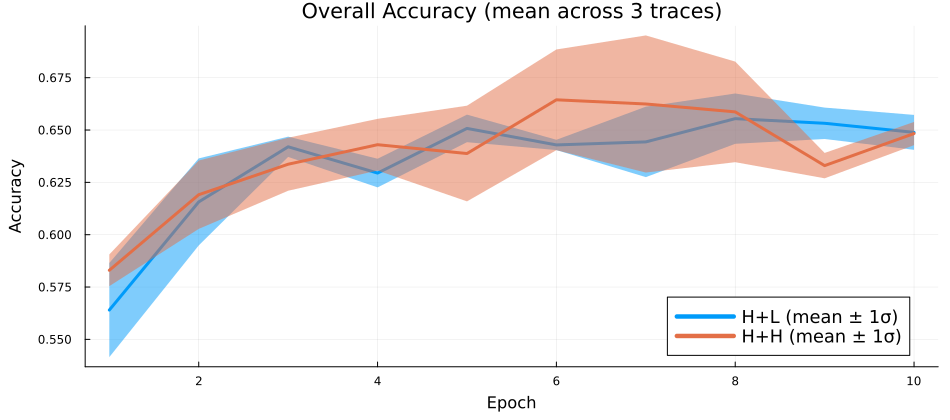

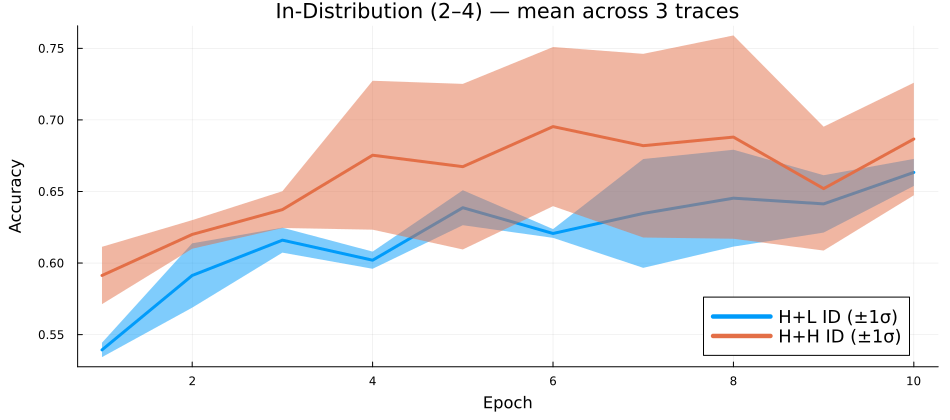

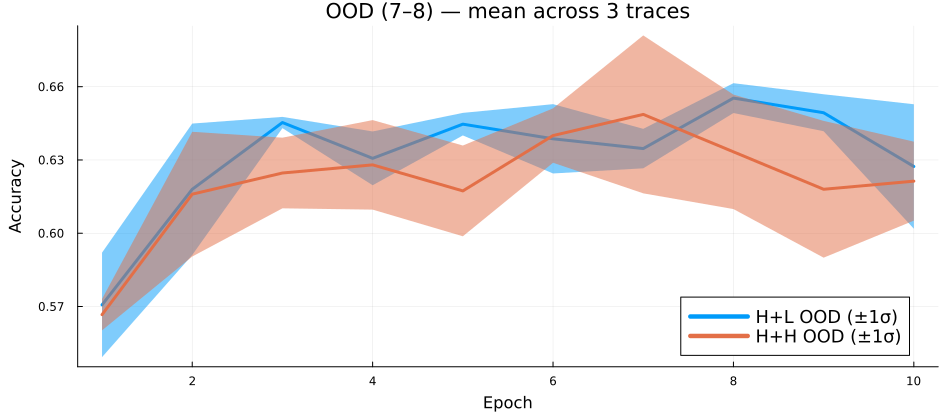

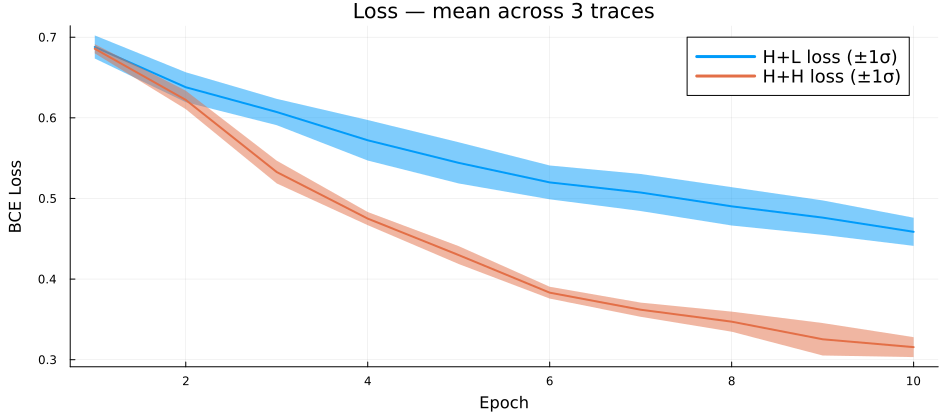

"/home/meow/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/loss_mean_vs_epoch.png"

In [38]:
# ===================== REPLACEMENT: averaged plots across traces =====================

using Statistics, StatsBase, DataFrames, CSV, Plots, Measures

# If you reloaded: df_traces_HL = CSV.read("hl_traces.csv", DataFrame)
#                  df_traces_HH = CSV.read("hh_traces.csv", DataFrame)

# Compute Overall per epoch per trace
df_traces_HL[!, :Overall] = (df_traces_HL.ID .+ df_traces_HL.MID .+ df_traces_HL.OOD) ./ 3
df_traces_HH[!, :Overall] = (df_traces_HH.ID .+ df_traces_HH.MID .+ df_traces_HH.OOD) ./ 3

# Aggregate by epoch (mean and std across traces)
function per_epoch_mean_std(df::DataFrame)
    g = groupby(df, :epoch)
    combine(g,
        :pB      => mean => :pB_mean,
        :loss    => mean => :loss_mean,    :loss    => std => :loss_std,
        :ID      => mean => :ID_mean,      :ID      => std => :ID_std,
        :MID     => mean => :MID_mean,     :MID     => std => :MID_std,
        :OOD     => mean => :OOD_mean,     :OOD     => std => :OOD_std,
        :Overall => mean => :Overall_mean, :Overall => std => :Overall_std,
        :OOD7    => mean => :OOD7_mean,    :OOD7    => std => :OOD7_std,
        :OOD8    => mean => :OOD8_mean,    :OOD8    => std => :OOD8_std,
    )
end

mean_HL = per_epoch_mean_std(df_traces_HL)
mean_HH = per_epoch_mean_std(df_traces_HH)

CSV.write("hl_mean_by_epoch.csv", mean_HL)
CSV.write("hh_mean_by_epoch.csv", mean_HH)

Plots.default(size=(950,420))

# --- Overall Accuracy (macro) ---
p_overall = plot(xlabel="Epoch", ylabel="Accuracy",
    title="Overall Accuracy (mean across $(TRACE_COUNT) traces)",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_overall, mean_HL.epoch, mean_HL.Overall_mean,
      ribbon=mean_HL.Overall_std, lw=3, label="H+L (mean ± 1σ)")
plot!(p_overall, mean_HH.epoch, mean_HH.Overall_mean,
      ribbon=mean_HH.Overall_std, lw=3, label="H+H (mean ± 1σ)")
display(p_overall)
savefig(p_overall, "overall_mean_vs_epoch.png")

# --- ID Accuracy ---
p_id = plot(xlabel="Epoch", ylabel="Accuracy",
    title="In-Distribution (2–4) — mean across $(TRACE_COUNT) traces",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_id, mean_HL.epoch, mean_HL.ID_mean,  ribbon=mean_HL.ID_std,  lw=3, label="H+L ID (±1σ)")
plot!(p_id, mean_HH.epoch, mean_HH.ID_mean,  ribbon=mean_HH.ID_std,  lw=3, label="H+H ID (±1σ)")
display(p_id)
savefig(p_id, "id_mean_vs_epoch.png")

# --- OOD Accuracy ---
p_ood = plot(xlabel="Epoch", ylabel="Accuracy",
    title="OOD (7–8) — mean across $(TRACE_COUNT) traces",
    legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_ood, mean_HL.epoch, mean_HL.OOD_mean, ribbon=mean_HL.OOD_std, lw=3, label="H+L OOD (±1σ)")
plot!(p_ood, mean_HH.epoch, mean_HH.OOD_mean, ribbon=mean_HH.OOD_std, lw=3, label="H+H OOD (±1σ)")
display(p_ood)
savefig(p_ood, "ood_mean_vs_epoch.png")

# --- Loss ---
p_loss = plot(xlabel="Epoch", ylabel="BCE Loss",
    title="Loss — mean across $(TRACE_COUNT) traces",
    legend=:topright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_loss, mean_HL.epoch, mean_HL.loss_mean, ribbon=mean_HL.loss_std, lw=2, label="H+L loss (±1σ)")
plot!(p_loss, mean_HH.epoch, mean_HH.loss_mean, ribbon=mean_HH.loss_std, lw=2, label="H+H loss (±1σ)")
display(p_loss)
savefig(p_loss, "loss_mean_vs_epoch.png")
# ================================================================================ 


In [37]:
import Pkg; Pkg.add("Measures")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Documents/repos/JuliaExploreHRM/Project.toml`
  [442fdcdd] + Measures v0.3.2
  No Changes to `~/Documents/repos/JuliaExploreHRM/Manifest.toml`


ArgumentError: ArgumentError: Package Measures not found in current path.
- Run `import Pkg; Pkg.add("Measures")` to install the Measures package.

In [25]:
CSV.write("hl_log.csv", to_dataframe(log_HL))
CSV.write("hh_log.csv", to_dataframe(log_HH))

CSV.write("summary_last.csv", summary_last)
CSV.write("summary_peak.csv", summary_peak)
CSV.write("diff_last.csv", diff_last)
# CSV.write("compact_summary.csv", df_compact)  


"diff_last.csv"

In [26]:

df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

Row,model,epoch,pB,loss,ID,MID,OOD,OOD7,OOD8
,String3,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,H+H,1,0.0,0.665541,0.657,0.626,0.617,0.63,0.604
2,H+H,2,0.0,0.57742,0.719,0.663,0.642,0.632,0.652
3,H+H,3,0.0,0.469665,0.8,0.642,0.633,0.622,0.644
4,H+H,4,0.0,0.414726,0.808,0.628,0.611,0.598,0.624
5,H+H,5,0.0,0.381939,0.858,0.639,0.602,0.596,0.608
6,H+H,6,0.0,0.368428,0.861,0.653,0.647,0.632,0.662
7,H+H,7,0.0,0.355037,0.871,0.651,0.636,0.61,0.662
8,H+H,8,0.0,0.337711,0.866,0.651,0.629,0.59,0.668
9,H+H,9,0.0,0.330758,0.877,0.657,0.633,0.62,0.646


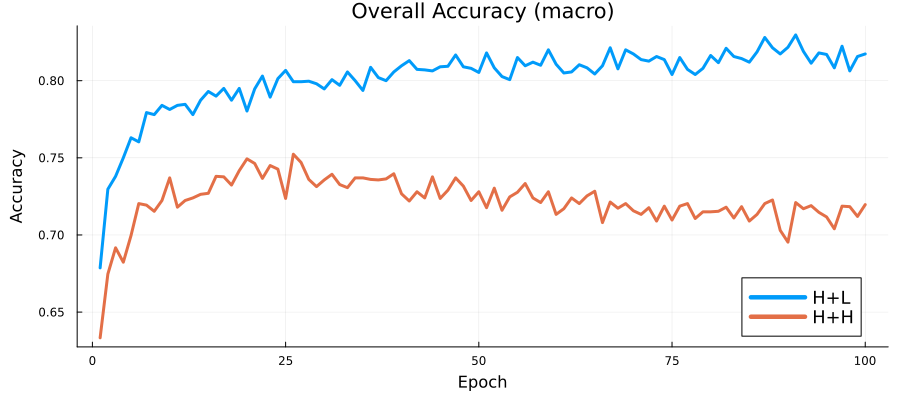

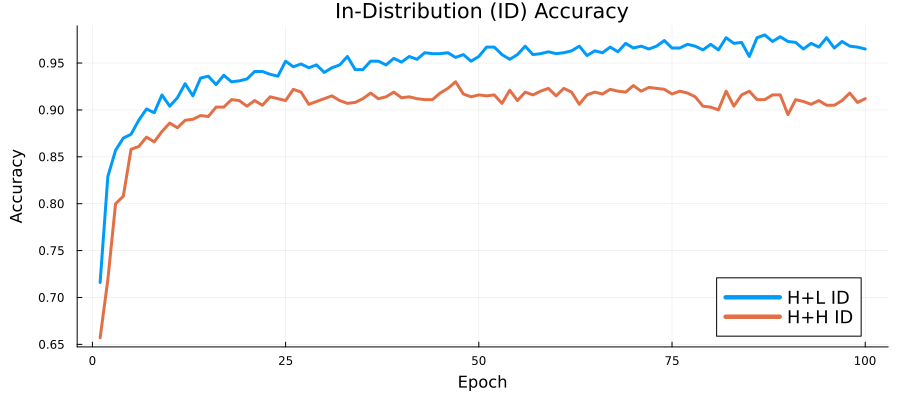

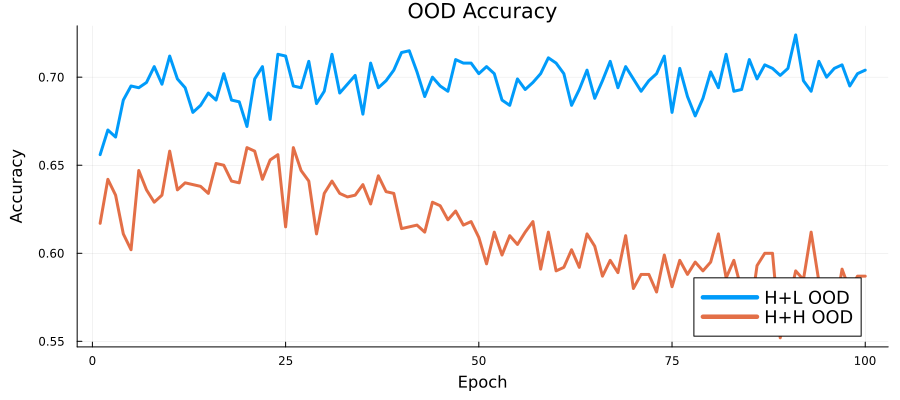

"ood_vs_epoch.png"

In [32]:


# --- Compute Overall (macro average) with a loop ---
overall_HL = Float64[]
overall_HH = Float64[]

for i in 1:nrow(df_HL)
    push!(overall_HL, (df_HL.ID[i] + df_HL.MID[i] + df_HL.OOD[i]) / 3)
end
for i in 1:nrow(df_HH)
    push!(overall_HH, (df_HH.ID[i] + df_HH.MID[i] + df_HH.OOD[i]) / 3)
end

df_HL.Overall = overall_HL
df_HH.Overall = overall_HH

# --- Simple plots ---
Plots.default(size=(900,400))

# Overall accuracy (macro)
p_overall = plot(xlabel="Epoch", ylabel="Accuracy", title="Overall Accuracy (macro)", legend=:bottomright,
                     left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_overall, df_HL.epoch, df_HL.Overall, lw=3, label="H+L")
plot!(p_overall, df_HH.epoch, df_HH.Overall, lw=3, ls=:solid, label="H+H")
display(p_overall)
png(p_overall, "overall_vs_epoch.png")

p_id = plot(xlabel="Epoch", ylabel="Accuracy", title="In-Distribution (ID) Accuracy",
            legend=:bottomright, left_margin=5mm, bottom_margin=5mm, legendfontsize=12)

plot!(p_id, df_HL.epoch, df_HL.ID, lw=3, label="H+L ID")
plot!(p_id, df_HH.epoch, df_HH.ID, lw=3, ls=:solid, label="H+H ID")

display(p_id)
png(p_id, "id_vs_epoch.png")

# OOD accuracy
p_ood = plot(xlabel="Epoch", ylabel="Accuracy", title="OOD Accuracy", legend=:bottomright,
                left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p_ood, df_HL.epoch, df_HL.OOD, lw=3, label="H+L OOD")
plot!(p_ood, df_HH.epoch, df_HH.OOD, lw=3, ls=:solid, label="H+H OOD")
display(p_ood)
png(p_ood, "ood_vs_epoch.png")

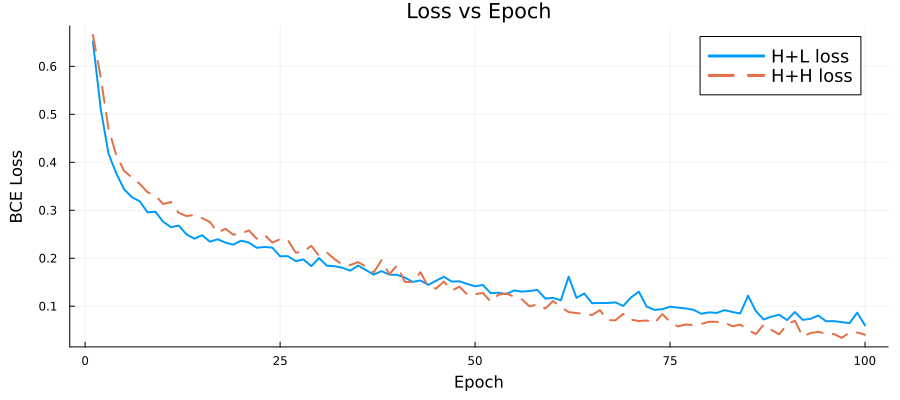

"/home/resort/Documents/repos/JuliaExploreHRM/05_nested_arithmetic_expression_Flux/LossVSepoc.png"

In [28]:
p4 = plot(title="Loss vs Epoch", xlabel="Epoch", ylabel="BCE Loss", legend=:topright,
left_margin=5mm, bottom_margin=5mm, legendfontsize=12)
plot!(p4, df_HL.epoch, df_HL.loss, lw=2, label="H+L loss")
plot!(p4, df_HH.epoch, df_HH.loss, lw=2, ls=:dash, label="H+H loss")
display(p4)
savefig(p4,"LossVSepoc.png")

In [31]:
using CSV, DataFrames, Dates

# --- Load logs ---
df_HL = CSV.read("hl_log.csv", DataFrame)
df_HH = CSV.read("hh_log.csv", DataFrame)

# --- Final summaries (plain indexing) ---
iL, iH = nrow(df_HL), nrow(df_HH)
summary_last = DataFrame(
    Model = ["H+L","H+H"],
    Epoch = [df_HL.epoch[iL], df_HH.epoch[iH]],
    pB    = [df_HL.pB[iL],    df_HH.pB[iH]],
    Loss  = [df_HL.loss[iL],  df_HH.loss[iH]],
    ID    = [df_HL.ID[iL],    df_HH.ID[iH]],
    MID   = [df_HL.MID[iL],   df_HH.MID[iH]],
    OOD   = [df_HL.OOD[iL],   df_HH.OOD[iH]],
    OOD7  = [df_HL.OOD7[iL],  df_HH.OOD7[iH]],
    OOD8  = [df_HL.OOD8[iL],  df_HH.OOD8[iH]],
)

iPeakHL, iPeakHH = argmax(df_HL.OOD), argmax(df_HH.OOD)
summary_peak = DataFrame(
    Model    = ["H+L","H+H"],
    PeakOOD  = [df_HL.OOD[iPeakHL], df_HH.OOD[iPeakHH]],
    AtEpoch  = [df_HL.epoch[iPeakHL], df_HH.epoch[iPeakHH]],
    pB       = [df_HL.pB[iPeakHL],    df_HH.pB[iPeakHH]],
    ID_at    = [df_HL.ID[iPeakHL],    df_HH.ID[iPeakHH]],
    MID_at   = [df_HL.MID[iPeakHL],   df_HH.MID[iPeakHH]],
)

diff_last = DataFrame(
    Metric = ["Loss","ID","MID","OOD","OOD7","OOD8"],
    Delta  = [summary_last.Loss[1]-summary_last.Loss[2],
              summary_last.ID[1]-summary_last.ID[2],
              summary_last.MID[1]-summary_last.MID[2],
              summary_last.OOD[1]-summary_last.OOD[2],
              summary_last.OOD7[1]-summary_last.OOD7[2],
              summary_last.OOD8[1]-summary_last.OOD8[2]],
)

# --- Simple LaTeX table function (using eachrow) ---
function df_to_latex_basic(df::DataFrame, caption::AbstractString="", label::AbstractString="")
    cols = names(df)
    aligns = [eltype(df[!, c]) <: Number ? "r" : "l" for c in cols]
    colspec = join(aligns, "")
    header  = join(string.(cols), " & ")

    io = IOBuffer()
    println(io, "\\begin{table}[t]")
    println(io, "\\centering")
    println(io, "\\begin{tabular}{", colspec, "}")
    println(io, "\\hline")
    println(io, header, " \\\\")
    println(io, "\\hline")
    for row in eachrow(df)
        vals = [string(row[c]) for c in cols]
        println(io, join(vals, " & "), " \\\\")
    end
    println(io, "\\hline")
    println(io, "\\end{tabular}")
    if !isempty(caption); println(io, "\\caption{", caption, "}"); end
    if !isempty(label);   println(io, "\\label{", label,   "}"); end
    println(io, "\\end{table}")
    return String(take!(io))
end

# --- Print LaTeX tables to REPL ---
println(df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final"))
println(df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak"))
println(df_to_latex_basic(diff_last,    "Final-epoch differences (H+L-H+H)", "tab:diff"))

# --- Save LaTeX tables to files ---
ts = Dates.format(now(), "yyyymmdd_HHMMSS")
open("summary_last_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_last, "Final-epoch summary", "tab:final")); end
open("summary_peak_$ts.tex","w") do io; write(io, df_to_latex_basic(summary_peak, "Peak OOD summary", "tab:peak")); end
open("diff_last_$ts.tex","w")  do io; write(io, df_to_latex_basic(diff_last, "Final-epoch differences (H+L-H+H)", "tab:diff")); end


\begin{table}[t]
\centering
\begin{tabular}{lrrrrrrrr}
\hline
Model & Epoch & pB & Loss & ID & MID & OOD & OOD7 & OOD8 \\
\hline
H+L & 100 & 1.0 & 0.05999790815203577 & 0.965 & 0.783 & 0.704 & 0.712 & 0.696 \\
H+H & 100 & 1.0 & 0.040605767602266654 & 0.912 & 0.66 & 0.587 & 0.596 & 0.578 \\
\hline
\end{tabular}
\caption{Final-epoch summary}
\label{tab:final}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lrrrrr}
\hline
Model & PeakOOD & AtEpoch & pB & ID_at & MID_at \\
\hline
H+L & 0.724 & 91 & 0.945514773925705 & 0.972 & 0.793 \\
H+H & 0.66 & 20 & 0.0 & 0.904 & 0.684 \\
\hline
\end{tabular}
\caption{Peak OOD summary}
\label{tab:peak}
\end{table}

\begin{table}[t]
\centering
\begin{tabular}{lr}
\hline
Metric & Delta \\
\hline
Loss & 0.019392140549769114 \\
ID & 0.052999999999999936 \\
MID & 0.123 \\
OOD & 0.11699999999999999 \\
OOD7 & 0.11599999999999999 \\
OOD8 & 0.118 \\
\hline
\end{tabular}
\caption{Final-epoch differences (H+L-H+H)}
\label{tab:diff}
\end{table}



324